
## Online/Offline 出し分けモデル

In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

In [3]:
# parameter
val_start_date = '2020-09-16'
#val_start_date = '2020-09-09'
#val_start_date = '2020-09-02'
#topk = 50
topk = 30


In [4]:
from datetime import datetime, date, timedelta
val_end_date = pd.to_datetime(val_start_date) + timedelta(days=7)

In [5]:
val_end_date = str(val_end_date.strftime('%Y-%m-%d'))
print(val_start_date, val_end_date)

2020-09-16 2020-09-23


In [6]:
# データの読み込み
dir = 'h-and-m-personalized-fashion-recommendations/'
path = '../input/' + dir 

#customers = pd.read_csv(path + 'customers.csv')
#articles = pd.read_csv(path + 'articles.csv')
transactions_train = pd.read_csv(path + 'transactions_train.csv')

In [7]:
# save memory https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
# 64文字もあるが、末尾16文字だけでcustomerを一意にid可能
# 使われている文字は0-9, a-fなので16進数で変換してintで扱える
# 16進数 = 4bit, 4bit * 16 / 8 = 8 byte
# 64 byte -> 8 byteに削減, int64で表現可能
transactions_train['customer_id'] = transactions_train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
# メモリ削減
transactions_train['article_id'] = transactions_train['article_id'].astype('int32')

In [8]:
sub = pd.read_csv(path + 'sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [9]:
sub['customer_id'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [10]:
visualize_df(transactions_train)

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.050831,2
1,2018-09-20,-6846340800584936,541518023,0.030492,2
2,2018-09-20,-8334631767138808638,505221004,0.015237,2
3,2018-09-20,-8334631767138808638,685687003,0.016932,2
4,2018-09-20,-8334631767138808638,685687004,0.016932,2


In [11]:
# 提出サンプルの確認
sub.head()

,customer_id
0,6883939031699146327
1,-7200416642310594310
2,-6846340800584936
3,-94071612138601410
4,-283965518499174310


### Divide data

In [12]:
# transactions_train['t_dat'].unique()[-7:]

# array(['2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19',
#       '2020-09-20', '2020-09-21', '2020-09-22'], dtype=object)


In [13]:
train_data = transactions_train.query(f"'{val_start_date}' <= t_dat and t_dat < '{val_end_date}'").reset_index(drop=True)
feature_data = transactions_train.query(f"t_dat < '{val_end_date}'").reset_index(drop=True) # 期間かぶっててもよい
visualize_df(train_data)

(240311, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-16,8055340703569116761,786022008,0.048441,2
1,2020-09-16,8055340703569116761,913272003,0.032288,2
2,2020-09-16,8055340703569116761,889669006,0.056508,2
3,2020-09-16,2563761487478961358,237347060,0.033881,1
4,2020-09-16,2563761487478961358,562245001,0.013542,1


### Online/Offlineに絞る

In [14]:
train_ch = feature_data.groupby('customer_id')['sales_channel_id'].agg('mean').reset_index(name='channel')
# 過去のデータだとchannel_idの計算ができないユーザーがいるので、onlineの2で埋めておく
# 最新データだと欠損ほぼないハズ
train_ch['channel'].fillna(2)

0          1.000000
1          1.964912
2          2.000000
3          2.000000
4          2.000000
             ...   
1362276    2.000000
1362277    1.200000
1362278    2.000000
1362279    2.000000
1362280    2.000000
Name: channel, Length: 1362281, dtype: float64

In [15]:
train_on = train_ch.query('channel >= 1.5')
train_off = train_ch.query('channel < 1.5')
train_on = train_on['customer_id']
train_off = train_off['customer_id']

In [16]:
train_on.shape

(928128,)

In [17]:
train_off.shape

(434153,)

In [18]:
train_ch.shape

(1362281, 2)

### customer_data

In [19]:
customers = pd.read_csv(path + 'customers.csv')
customers['customer_id'] = customers['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,-94071612138601410,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,-283965518499174310,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [20]:
customers = customers[['customer_id','age']]
customers.head()

,customer_id,age
0,6883939031699146327,49.0
1,-7200416642310594310,25.0
2,-6846340800584936,24.0
3,-94071612138601410,54.0
4,-283965518499174310,52.0


In [21]:
customers.describe()

,customer_id,age
count,1.371980e+06,1.356119e+06
mean,-8.899354e+15,3.638696e+01
std,5.326640e+18,1.431363e+01
min,-9.223353e+18,1.600000e+01
25%,-4.624561e+18,2.400000e+01
50%,-1.147651e+16,3.200000e+01
75%,4.602000e+18,4.900000e+01
max,9.223371e+18,9.900000e+01


In [22]:
# 年齢がないものは0歳としておく (''だと後からintにcastできないため)
train_data = pd.merge(train_data, customers, on='customer_id', how='left').fillna('0')

In [23]:
train_data.dtypes

t_dat                object
customer_id           int64
article_id            int32
price               float64
sales_channel_id      int64
age                  object
dtype: object

In [24]:
train_data['age'].value_counts()

25.0    12235
26.0    12182
24.0    12136
23.0    10778
27.0    10544
        ...  
88.0        4
90.0        3
98.0        2
94.0        1
92.0        1
Name: age, Length: 78, dtype: int64

In [25]:
train_data['age'] = train_data['age'].astype('int32')
train_data.dtypes

t_dat                object
customer_id           int64
article_id            int32
price               float64
sales_channel_id      int64
age                   int32
dtype: object

In [26]:
train_data_on = pd.merge(train_data, train_on, on='customer_id', how='inner')
train_data_off = pd.merge(train_data, train_off, on='customer_id', how='inner')
train_data_on

,t_dat,customer_id,article_id,price,sales_channel_id,age
0,2020-09-16,8055340703569116761,786022008,0.048441,2,42
1,2020-09-16,8055340703569116761,913272003,0.032288,2,42
2,2020-09-16,8055340703569116761,889669006,0.056508,2,42
3,2020-09-18,8055340703569116761,913272003,0.033881,2,42
4,2020-09-18,8055340703569116761,889669006,0.059305,2,42
...,...,...,...,...,...,...
178518,2020-09-22,-5420368482568489295,832505003,0.025407,2,30
178519,2020-09-22,-5420368482568489295,902288001,0.022017,2,30
178520,2020-09-22,-5420368482568489295,856440002,0.042356,2,30
178521,2020-09-22,-8639340045377511665,833459002,0.006763,1,21


In [27]:
train_off

0         -9223352921020755230
8         -9223290575350349271
12        -9223266757075030900
18        -9223217056923624798
19        -9223211958423060038
                  ...         
1362264    9223106377186991822
1362267    9223141695752178477
1362269    9223148401910457466
1362270    9223180691543279742
1362277    9223333063893176977
Name: customer_id, Length: 434153, dtype: int64

### 単純なランキングから上位50件を取ってくる

In [28]:
# -30, 30-40, 40-50, 50- old
# -30, 30-50, 50- new
train_sort_30_on = train_data_on.query('age < 30').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_50_on = train_data_on.query('30 <= age and age < 50').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_60_on = train_data_on.query('50 <= age').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)

train_sort_30_off = train_data_off.query('age < 30').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_50_off = train_data_off.query('30 <= age and age < 50').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_60_off = train_data_off.query('50 <= age').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)

In [29]:
popular_list_30_on = train_sort_30_on.head(topk)['article_id'].tolist()
popular_list_50_on = train_sort_50_on.head(topk)['article_id'].tolist()
popular_list_60_on = train_sort_60_on.head(topk)['article_id'].tolist()

popular_list_30_off = train_sort_30_off.head(topk)['article_id'].tolist()
popular_list_50_off = train_sort_50_off.head(topk)['article_id'].tolist()
popular_list_60_off = train_sort_60_off.head(topk)['article_id'].tolist()

### Visualize

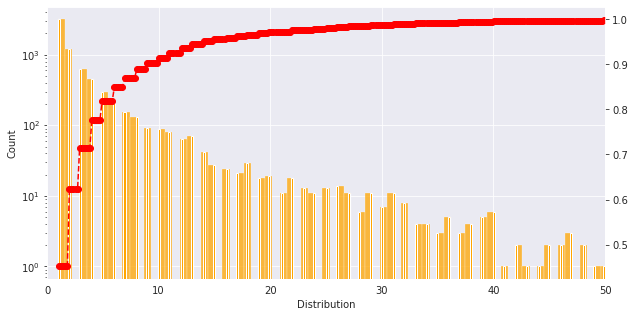

In [30]:
# 30
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_30_off, x='customer_id', bins=200, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 50)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_30_off, x='customer_id', bins=700, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

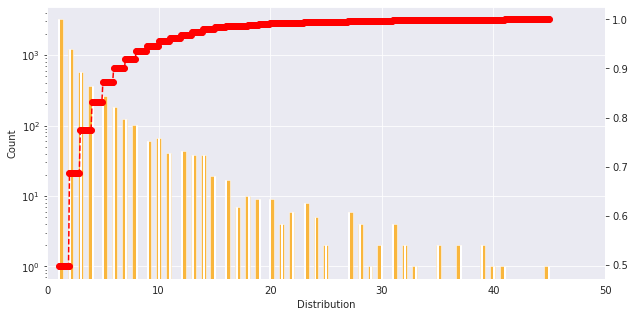

In [31]:
# 30 - 50

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_50_off, x='customer_id', bins=100, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 50)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_50_off, x='customer_id', bins=500, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

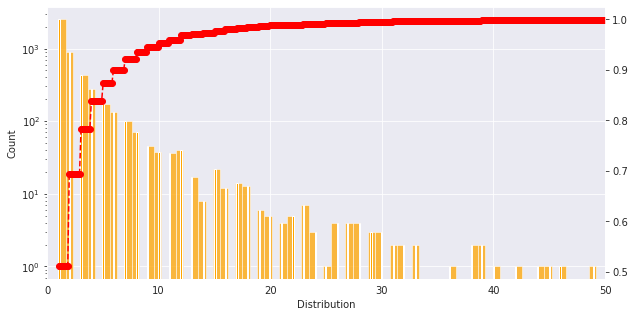

In [32]:
# 50 - 

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_60_off, x='customer_id', bins=100, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 50)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_60_off, x='customer_id', bins=500, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

### Popular list

In [33]:
cnt=0
for i in popular_list_30_on:
    if i in popular_list_60_on:
        cnt+= 1
print('ratio=', cnt/100)

cnt=0
for i in popular_list_30_on[:30]:
    if i in popular_list_60_on[:30]:
        cnt+= 1
print('ratio 50=', cnt/30)

ratio= 0.13
ratio 50= 0.43333333333333335


In [34]:
popular_str_30_on = [str(i) for i in popular_list_30_on]
popular_str_50_on = [str(i) for i in popular_list_50_on]
popular_str_60_on = [str(i) for i in popular_list_60_on]

popular_str_30_off = [str(i) for i in popular_list_30_off]
popular_str_50_off = [str(i) for i in popular_list_50_off]
popular_str_60_off = [str(i) for i in popular_list_60_off]

In [35]:
join_popular_30_on = ' '.join(popular_str_30_on)
join_popular_50_on = ' '.join(popular_str_50_on)
join_popular_60_on = ' '.join(popular_str_60_on)

join_popular_30_off = ' '.join(popular_str_30_off)
join_popular_50_off = ' '.join(popular_str_50_off)
join_popular_60_off = ' '.join(popular_str_60_off)

In [36]:
join_popular_30_on

'924243001 448509014 866731001 924243002 915529005 923758001 918522001 909370001 929275001 934835001 918292001 788575004 762846027 896169005 909059002 714790020 788575002 915529003 715624001 894780001 865799006 863583001 573085028 573085042 751471001 706016003 850917001 706016001 889550002 919273002'

In [37]:
# subにcustomerをjoin
sub2 =  pd.merge(sub, customers, on='customer_id', how='left').fillna('0')
sub2['age'] = sub2['age'].astype('int32')

In [38]:
sub2

,customer_id,age
0,6883939031699146327,49
1,-7200416642310594310,25
2,-6846340800584936,24
3,-94071612138601410,54
4,-283965518499174310,52
...,...,...
1371975,7551062398649767985,24
1371976,-9141402131989464905,21
1371977,-8286316756823862684,21
1371978,2551401172826382186,18


In [39]:
train_off = pd.DataFrame(train_off)
train_off['flag'] = 0

In [40]:
sub2['flag'] = 1
sub2 = pd.merge(sub2, train_off, on='customer_id', how='left').fillna('0')

In [41]:
sub2

,customer_id,age,flag_x,flag_y
0,6883939031699146327,49,1,0
1,-7200416642310594310,25,1,0
2,-6846340800584936,24,1,0
3,-94071612138601410,54,1,0
4,-283965518499174310,52,1,0
...,...,...,...,...
1371975,7551062398649767985,24,1,0
1371976,-9141402131989464905,21,1,0
1371977,-8286316756823862684,21,1,0
1371978,2551401172826382186,18,1,0


In [42]:
sub2['flag_x'] = sub2['flag_x'].astype('int8')
sub2['flag_y'] = sub2['flag_y'].astype('int8')
sub2['flag'] = sub2['flag_x'] + sub2['flag_y']
sub2 = sub2.drop(columns='flag_x')
sub2 = sub2.drop(columns='flag_y')

In [43]:
sub2

,customer_id,age,flag
0,6883939031699146327,49,1
1,-7200416642310594310,25,1
2,-6846340800584936,24,1
3,-94071612138601410,54,1
4,-283965518499174310,52,1
...,...,...,...
1371975,7551062398649767985,24,1
1371976,-9141402131989464905,21,1
1371977,-8286316756823862684,21,1
1371978,2551401172826382186,18,1


In [44]:
sub2.loc[(sub2['age'] < 30) & (sub2['flag'] == 1), ['prediction']] = join_popular_30_on
sub2.loc[(30 <= sub2['age']) & (sub2['age'] < 50) & (sub2['flag'] == 1), ['prediction']] = join_popular_50_on
sub2.loc[(50 <= sub2['age']) & (sub2['flag'] == 1), ['prediction']] = join_popular_60_on

sub2.loc[(sub2['age'] < 30) & (sub2['flag'] == 0), ['prediction']] = join_popular_30_off
sub2.loc[(30 <= sub2['age']) & (sub2['age'] < 50) & (sub2['flag'] == 0), ['prediction']] = join_popular_50_off
sub2.loc[(50 <= sub2['age']) & (sub2['flag'] == 0), ['prediction']] = join_popular_60_off

In [45]:
sub = sub2

### Submit

In [46]:
print(sub.shape)

(1371980, 4)


In [47]:
sub = sub.drop(columns='age')
sub

,customer_id,flag,prediction
0,6883939031699146327,1,923758001 924243001 915529003 919273002 924243...
1,-7200416642310594310,1,924243001 448509014 866731001 924243002 915529...
2,-6846340800584936,1,924243001 448509014 866731001 924243002 915529...
3,-94071612138601410,1,930380001 924243001 924243002 928206001 751471...
4,-283965518499174310,1,930380001 924243001 924243002 928206001 751471...
...,...,...,...
1371975,7551062398649767985,1,924243001 448509014 866731001 924243002 915529...
1371976,-9141402131989464905,1,924243001 448509014 866731001 924243002 915529...
1371977,-8286316756823862684,1,924243001 448509014 866731001 924243002 915529...
1371978,2551401172826382186,1,924243001 448509014 866731001 924243002 915529...


In [48]:
# backfill用のcsv書き出し、上位50件、直近1週間
sub.to_csv(f'ranking_{val_start_date}_{topk}_ch.csv', index=False)